# Settings

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import plot_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2
import random
from time import time

Using TensorFlow backend.


# Prepare data

In [2]:
def prepare_data():
    """ Divides data into images and labels.
        Substracts mean per-channel image calculated on the training set from all images.
        Then normalizes pixel values between -1 and 1.
    """
    patches = glob.glob('./padded/*.png')
    X = []
    y = []

    for img_name in patches[:10000]:
        image = cv2.imread(img_name)
        X.append(image)
        y.append(0) if img_name.endswith('class0.png') else y.append(1)
    
    X_train_tune, X_test, y_train_tune, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_tune, y_train, y_tune = train_test_split(X_train_tune, y_train_tune, test_size=0.1, random_state=42)
    
    mean_img = np.mean(X_train, axis = 0)
    X_train -= mean_img
    X_train = 2 * (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train)) - 1
    X_test -= mean_img
    X_test = 2 * (X_test - np.min(X_test))/(np.max(X_test) - np.min(X_test)) - 1
    X_tune -= mean_img
    X_tune = 2 * (X_tune - np.min(X_tune))/(np.max(X_tune) - np.min(X_tune)) - 1
    
    y_train_onehot = np_utils.to_categorical(y_train, 2)
    y_tune_onehot = np_utils.to_categorical(y_tune, 2)
    y_test_onehot = np_utils.to_categorical(y_test, 2)
    
    return X_train, X_tune, X_test, y_train_onehot, y_tune_onehot, y_test_onehot

# Build a ConvNet

In [3]:
def create_CNN():
    input_shape = (50, 50, 3)
    num_classes = 2
    reg = 0.0001
    
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [4]:
cnn_pad = create_CNN()
cnn_pad.summary()
plot_model(cnn_pad, to_file='simple_cnn_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
__________

# Analyze the training set

In [5]:
X_train, X_tune, X_test, y_train, y_tune, y_test = prepare_data()

print(X_train.shape)
print(np.min(X_train), np.max(X_train))
print(np.min(X_test), np.max(X_test))
print(np.min(X_tune), np.max(X_tune))

(8100, 50, 50, 3)
-1.0 1.0
-1.0 1.0
-1.0 1.0


In [6]:
print((y_train[:,1]==1).sum()) # positive examples
print((y_train[:,0]==1).sum()) # negative examples

2281
5819


In [7]:
def balance(X, y):
    """ Function for getting perfectly balanced data set (50/50)
        Takes as many negative examples, as there are positive ones
        DON'T USE IT IF YOUR DATASET IS OK
    """
    X0 = []
    X1 = []
    for i in range(0, len(y)):
        X1.append(X[i]) if y[i] == 1 else X0.append(X[i]) 
    X0 = np.array(X0)
    X1 = np.array(X1)
    
    X0 = X0[:len(X1)]
    X_balanced = np.concatenate((X0, X1))

    a = [0] * len(X0) 
    b = [1] * len(X1)
    y_balanced = a + b

    return X_balanced, y_balanced
    
#X, y = balance(X, y)

# Train and evaluate the network

In [8]:
epochs = 15
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}{}".format(time(),'_centered_split_xavier_norm'), histogram_freq=1, 
                          batch_size=batch_size, 
                          write_grads=True, write_images=False)

fit_history = cnn_pad.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs, shuffle=True, 
                          verbose=1, validation_data=(X_tune, y_tune), callbacks=[tensorboard, early_stopping])

Train on 8100 samples, validate on 900 samples
Epoch 1/10
8100/8100 [==============================] - 244s 30ms/step - loss: 0.6968 - acc: 0.7902 - val_loss: 0.6414 - val_acc: 0.8222
Epoch 2/10
8100/8100 [==============================] - 267s 33ms/step - loss: 0.5313 - acc: 0.8302 - val_loss: 0.5332 - val_acc: 0.8333
Epoch 3/10
8100/8100 [==============================] - 276s 34ms/step - loss: 0.4937 - acc: 0.8399 - val_loss: 0.5416 - val_acc: 0.8300
Epoch 4/10
8100/8100 [==============================] - 240s 30ms/step - loss: 0.4768 - acc: 0.8460 - val_loss: 0.4949 - val_acc: 0.8433
Epoch 5/10
8100/8100 [==============================] - 236s 29ms/step - loss: 0.4732 - acc: 0.8446 - val_loss: 0.4581 - val_acc: 0.8478
Epoch 6/10
8100/8100 [==============================] - 226s 28ms/step - loss: 0.4486 - acc: 0.8502 - val_loss: 0.5114 - val_acc: 0.8100
Epoch 7/10
8100/8100 [==============================] - 218s 27ms/step - loss: 0.4400 - acc: 0.8519 - val_loss: 0.5018 - val_acc: 0

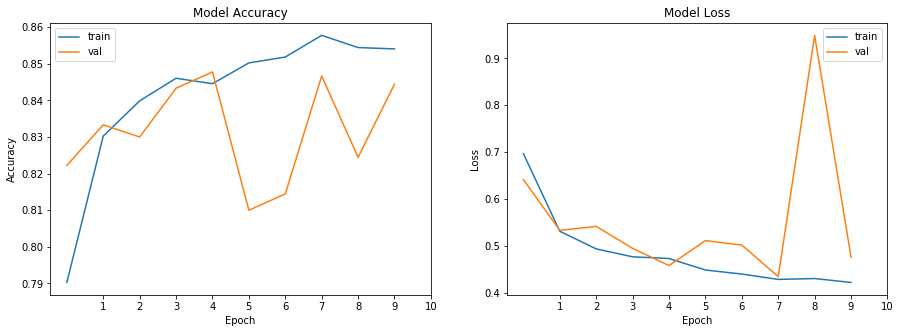

In [9]:
def plot_history(history):
    """ Util function for plotting model's accuracy and loss
        Could be deleted since all the info is in Tensorboard
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_xticks(np.arange(1, len(history.history['acc'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_xticks(np.arange(1, len(history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_history(fit_history)

# Evaluate the performance on the test set

In [10]:
#score_pad = cnn_pad.evaluate(X_test, y_test_onehot, verbose=0)
#print('Test loss:', score_pad[0])
#print('Test accuracy:', score_pad[1])

#plt.plot(fit_history.history['loss'])
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.title('Simple CNN with padded imgs')
#plt.show()